2. Consider the diffusion equation:

$u_t = u_{xx}, \quad 0\le x\le 1, \quad t\ge 0$

with initial and boundary conditions

$u(x, 0) = \sin\left(\frac{1}{2}\pi x\right) + \frac{1}{2}\sin(2\pi x), \quad u(0, t) = 0, \quad u(1,t) = e^{-\pi^2 t/4}, \quad t\ge 0.$

Solve the problem using Forward Euler finite difference method with $\mu=0.5$ and $\mu=0.509$

Forward Euler with mu = 0.5, N = 50, T = 0.02
  dt = 2.000e-04, actual mu = 0.500000
  max error at final time = 4.754e-04
  max solution magnitude at final time = 9.518e-01
Forward Euler with mu = 0.509, N = 50, T = 0.02
  dt = 2.020e-04, actual mu = 0.505051
  max error at final time = 4.826e-04
  max solution magnitude at final time = 9.518e-01


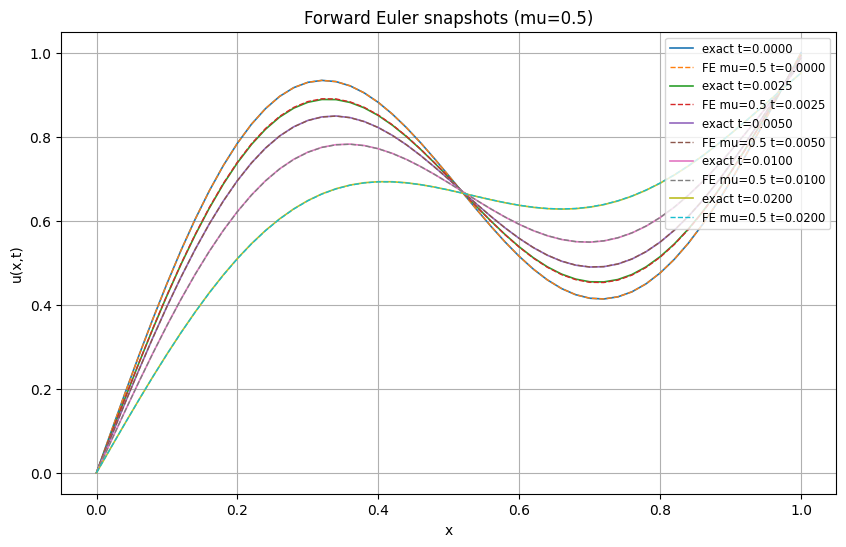

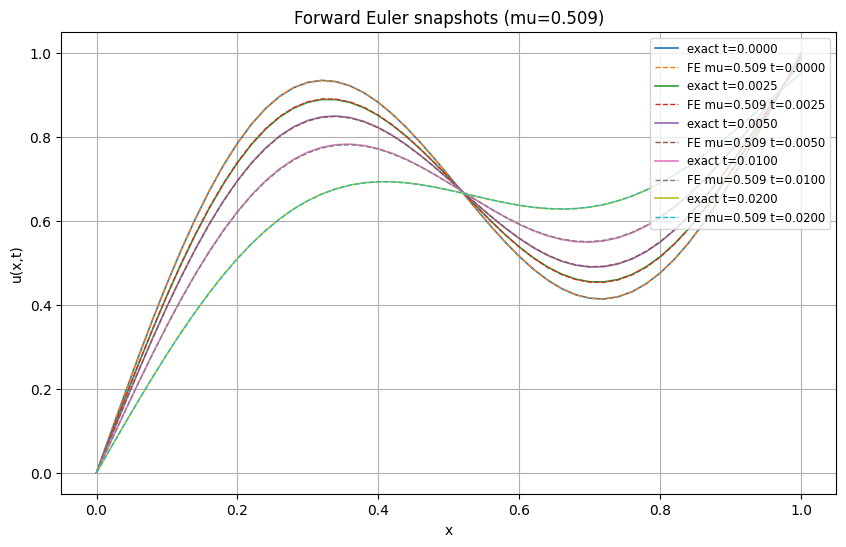

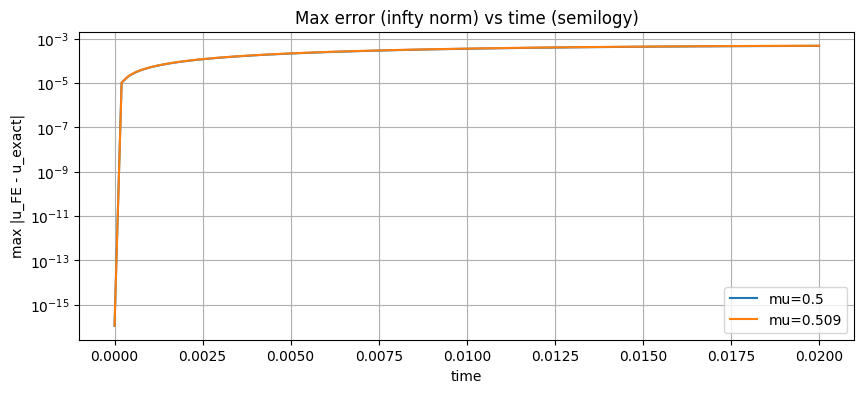

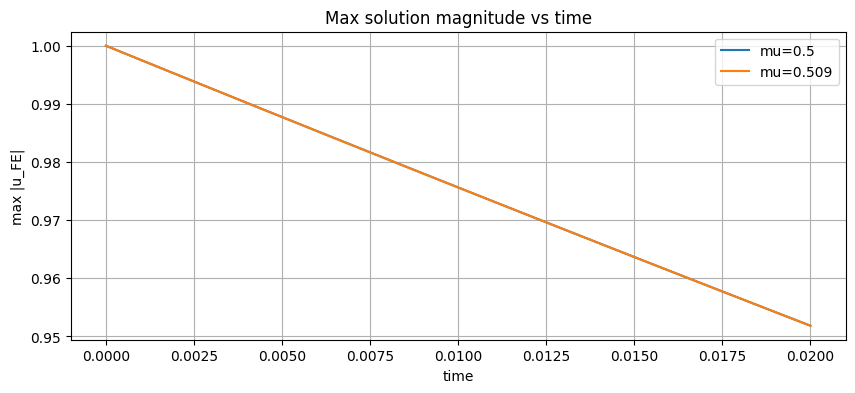

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def initial_condition(x):
    return np.sin(0.5 * np.pi * x) + 0.5 * np.sin(2.0 * np.pi * x)

def exact_solution(x, t):
    return (np.sin(0.5 * np.pi * x) * np.exp(- (np.pi**2) * t / 4.0)
            + 0.5 * np.sin(2.0 * np.pi * x) * np.exp(-4.0 * (np.pi**2) * t))

def boundary_right(t):
    return np.exp(- (np.pi**2) * t / 4.0)

#Forward Euler
def forward_euler(mu, N, T, snapshot_times=None):
    h = 1.0 / N
    dt = mu * h**2
    Nt = int(np.ceil(T / dt))
    dt = T / Nt   # adjust dt so that Nt*dt = T
    mu = dt / h**2

    x = np.linspace(0, 1, N+1)
    u = initial_condition(x)
    # enforce boundary at t=0
    u[0] = 0.0
    u[-1] = boundary_right(0.0)

    times = np.linspace(0, T, Nt+1)
    snapshots = {}
    if snapshot_times is None:
        # default snapshot times
        snapshot_times = [0.0, 0.001, 0.005, 0.01, T]

    # arrays to track errors and max amplitude
    max_err = np.zeros(Nt+1)
    max_val = np.zeros(Nt+1)

    # initial error
    u_ex = exact_solution(x, 0.0)
    max_err[0] = np.max(np.abs(u - u_ex))
    max_val[0] = np.max(np.abs(u))

    if 0.0 in snapshot_times:
        snapshots[0.0] = u.copy()

    # time-stepping
    for n in range(Nt):
        t = n * dt
        u_new = u.copy()
        u_new[1:-1] = u[1:-1] + mu * (u[2:] - 2.0 * u[1:-1] + u[:-2])

        # enforce Dirichlet BCs at new time t+dt
        u_new[0] = 0.0
        u_new[-1] = boundary_right(t + dt)

        # advance
        u = u_new

        # diagnostics
        current_time = (n+1) * dt
        u_ex = exact_solution(x, current_time)
        max_err[n+1] = np.max(np.abs(u - u_ex))
        max_val[n+1] = np.max(np.abs(u))

        # store snapshot if requested
        for st in snapshot_times:
            if abs(current_time - st) <= 0.5*dt:
                snapshots[round(st,10)] = u.copy()

    diagnostics = {
        'x': x,
        'times': times,
        'u_final': u,
        'max_err': max_err,
        'max_val': max_val,
        'snapshots': snapshots,
        'dt': dt,
        'mu_actual': mu
    }
    return diagnostics

# run for mu=0.5 and mu=0.509
if __name__ == "__main__":
    N = 50
    T = 0.02
    mus = [0.5, 0.509]
    snapshot_times = [0.0, 0.0025, 0.005, 0.01, 0.02]

    results = {}
    for mu in mus:
        print(f"Forward Euler with mu = {mu}, N = {N}, T = {T}")
        res = forward_euler(mu=mu, N=N, T=T, snapshot_times=snapshot_times)
        print(f"  dt = {res['dt']:.3e}, actual mu = {res['mu_actual']:.6f}")
        print(f"  max error at final time = {res['max_err'][-1]:.3e}")
        print(f"  max solution magnitude at final time = {res['max_val'][-1]:.3e}")
        results[mu] = res

    # plot
    for mu, res in results.items():
        x = res['x']
        snaps = res['snapshots']
        plt.figure(figsize=(10,6))
        for t in sorted(snaps.keys()):
            u_num = snaps[t]
            u_ex = exact_solution(x, t)
            plt.plot(x, u_ex, '-', label=f'exact t={t:.4f}', linewidth=1.2)
            plt.plot(x, u_num, '--', label=f'FE mu={mu} t={t:.4f}', linewidth=1.0)
        plt.title(f'Forward Euler snapshots (mu={mu})')
        plt.xlabel('x'); plt.ylabel('u(x,t)'); plt.legend(loc='upper right', fontsize='small')
        plt.grid(True)
        plt.show()

    plt.figure(figsize=(10,4))
    for mu, res in results.items():
        times = res['times']
        plt.semilogy(times, res['max_err'], label=f'mu={mu}')
    plt.title('Max error (infty norm) vs time (semilogy)')
    plt.xlabel('time'); plt.ylabel('max |u_FE - u_exact|'); plt.legend(); plt.grid(True)
    plt.show()

    plt.figure(figsize=(10,4))
    for mu, res in results.items():
        times = res['times']
        plt.plot(times, res['max_val'], label=f'mu={mu}')
    plt.title('Max solution magnitude vs time')
    plt.xlabel('time'); plt.ylabel('max |u_FE|'); plt.legend(); plt.grid(True)
    plt.show()


3. Consider the diffusion equation:

$u_t = u_{xx}, \quad 0\le x\le 1, \quad t\ge 0$

with initial and boundary conditions


$u(x, 0) = \sin\left(2\pi x\right)e^{x}, \quad u(0, t) = u(1,t) = 0, \quad t\ge 0.$

With the aid of Fast Since transform, solve the problem using (a) finite difference method and (b) method of line approach to $T=1$. Find the order of convergence.


Convergence study for Crank-Nicolson
CN: N=  50, h=2.000e-02, dt=8.000e-03, L2_h error=6.314e-08
CN: N= 100, h=1.000e-02, dt=4.000e-03, L2_h error=1.172e-08
CN: N= 200, h=5.000e-03, dt=2.000e-03, L2_h error=2.262e-09
CN: N= 400, h=2.500e-03, dt=1.000e-03, L2_h error=4.606e-10
CN empirical rates (L2):
50->100: rate ≈ 2.430
100->200: rate ≈ 2.372
200->400: rate ≈ 2.296

Convergence study for Method of Lines 
MOL: N=  50, h=2.000e-02, L2_h error=3.591e-08
MOL: N= 100, h=1.000e-02, L2_h error=9.088e-09
MOL: N= 200, h=5.000e-03, L2_h error=2.391e-09
MOL: N= 400, h=2.500e-03, L2_h error=7.096e-10
MOL empirical rates (L2):
50->100: rate ≈ 1.982
100->200: rate ≈ 1.926
200->400: rate ≈ 1.753


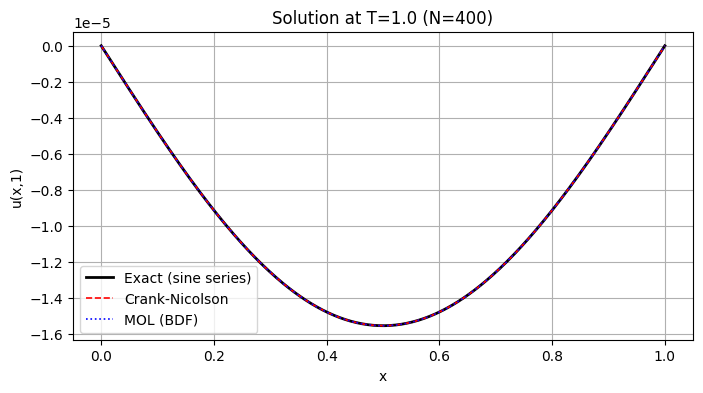

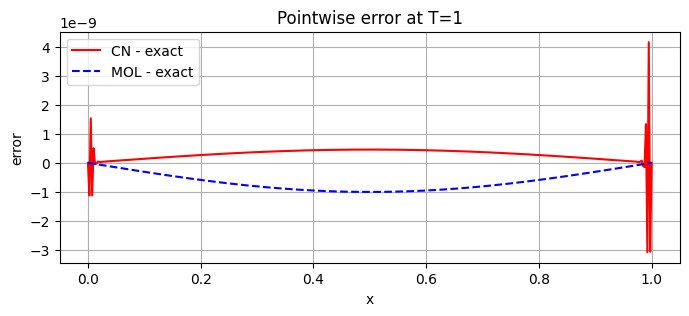

In [8]:
import numpy as np
import matplotlib.pyplot as plt

try:
    from scipy.integrate import solve_ivp
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False
    print("Warning: scipy not found — MOL will not run with solve_ivp. Install scipy for MOL.")


T_FINAL = 1.0

def u0_fun(x):
    return np.sin(2.0 * np.pi * x) * np.exp(x)

def compute_sine_coefficients(u0_func, Kmax, Nquad=20001):
    xq = np.linspace(0.0, 1.0, Nquad)
    hq = xq[1] - xq[0]
    u0q = u0_func(xq)
    a = np.zeros(Kmax+1)
    for k in range(1, Kmax+1):
        sk = np.sin(k * np.pi * xq)
        # composite trapezoid
        integral = np.trapezoid(u0q * sk, xq)
        a[k] = 2.0 * integral
    return a

def exact_by_sine(u0_func, x, t, Kmax, coeffs=None):
    """
    Reconstruct exact solution at nodes x and time t using first Kmax sine modes.
    If coeffs provided, use them (array indexed from 0..Kmax).
    """
    if coeffs is None:
        coeffs = compute_sine_coefficients(u0_func, Kmax)
    u = np.zeros_like(x, dtype=float)
    for k in range(1, Kmax+1):
        u += coeffs[k] * np.exp(-(k * np.pi)**2 * t) * np.sin(k * np.pi * x)
    return u


def thomas_tridiag(a, b, c, d):
    m = len(b)
    cp = np.zeros(m-1)
    dp = np.zeros(m)
    cp[0] = c[0] / b[0]
    dp[0] = d[0] / b[0]
    for i in range(1, m-1):
        denom = b[i] - a[i-1] * cp[i-1]
        cp[i] = c[i] / denom
        dp[i] = (d[i] - a[i-1] * dp[i-1]) / denom
    denom = b[m-1] - a[m-2] * cp[m-2]
    dp[m-1] = (d[m-1] - a[m-2] * dp[m-2]) / denom
    x = np.zeros(m)
    x[-1] = dp[-1]
    for i in range(m-2, -1, -1):
        x[i] = dp[i] - cp[i] * x[i+1]
    return x

def crank_nicolson_solver(N, dt, Tfinal, u0_func):
    h = 1.0 / N
    x = np.linspace(0, 1, N+1)
    Nt = int(np.ceil(Tfinal / dt))
    dt = Tfinal / Nt  # adjust dt so Nt*dt = Tfinal
    mu = dt / h**2

    # number of unknown interior points
    m = N - 1
    aL = np.full(m-1, -0.5 * mu)  # sub diag of LHS (corresponds to u_{j-1})
    bL = np.full(m, 1.0 + mu)     # main diag of LHS (1 - 0.5*dt*(-2/h^2) = 1 + mu)
    cL = np.full(m-1, -0.5 * mu)

    aR = np.full(m-1, 0.5 * mu)
    bR = np.full(m, 1.0 - mu)
    cR = np.full(m-1, 0.5 * mu)

    # initial condition
    u = u0_func(x)
    # enforce Dirichlet BCs
    u[0] = 0.0
    u[-1] = 0.0

    # time stepping
    t = 0.0
    for n in range(Nt):
        # build RHS vector d = RHS_mat * u_interior + BC contributions
        u_int = u[1:-1].copy()
        d = bR * u_int
        if m > 1:
            d[:-1] += aR * u_int[1:]      # shift: careful indices -> easier do full conv
            d[1:]  += cR * u_int[:-1]
        # boundary contributions
        # solve LHS * u_new_int = d
        u_new_int = thomas_tridiag(aL, bL, cL, d)
        # assemble full u
        u[1:-1] = u_new_int
        t += dt
    return x, u


def mol_solver(N, Tfinal, u0_func, rtol=1e-8, atol=1e-10):
    if not SCIPY_AVAILABLE:
        raise RuntimeError("scipy is required for MOL solve_ivp; install scipy and retry.")
    h = 1.0 / N
    x = np.linspace(0, 1, N+1)
    m = N - 1  # interior unknowns
    def rhs(t, u_int):
        # u_int is length m (u1..u_{N-1})
        dudt = np.zeros_like(u_int)
        if m == 1:
            dudt[0] = ( -2.0 * u_int[0] + 0.0 ) / h**2
        else:
            # leftmost
            dudt[0] = (u_int[1] - 2.0 * u_int[0] + 0.0) / h**2
            # middle
            dudt[1:-1] = (u_int[2:] - 2.0 * u_int[1:-1] + u_int[:-2]) / h**2
            # rightmost
            dudt[-1] = (0.0 - 2.0 * u_int[-1] + u_int[-2]) / h**2
        return dudt

    u_full0 = u0_func(x)
    u_full0[0] = 0.0; u_full0[-1] = 0.0
    u_int0 = u_full0[1:-1]
    sol = solve_ivp(rhs, [0.0, Tfinal], u_int0, method='BDF', rtol=rtol, atol=atol)
    if not sol.success:
        raise RuntimeError("solve_ivp failed: " + str(sol.message))
    u_int_final = sol.y[:, -1]
    u = np.zeros(N+1)
    u[1:-1] = u_int_final
    u[0] = 0.0; u[-1] = 0.0
    return x, u


def L2h_error(u_num, u_ex, h):
    # u_num and u_ex defined on same grid
    err = u_num - u_ex
    return np.sqrt(h * np.sum(err**2))

def convergence_study_CN(N_list, dt_factor=0.4):
    # dt_factor sets dt relative to h: dt = dt_factor * h
    results = []
    for N in N_list:
        h = 1.0 / N
        dt = dt_factor * h
        x_num, u_num = crank_nicolson_solver(N, dt, T_FINAL, u0_fun)
        # exact: pick Kmax sufficiently large: use Kmax = max(200, 6*N)
        Kmax = max(200, 6 * N)
        coeffs = compute_sine_coefficients(u0_fun, Kmax, Nquad=20001)
        u_ex = exact_by_sine(u0_fun, x_num, T_FINAL, Kmax, coeffs=coeffs)
        err = L2h_error(u_num, u_ex, h)
        results.append((N, h, err))
        print(f"CN: N={N:4d}, h={h:.3e}, dt={dt:.3e}, L2_h error={err:.3e}")
    # compute empirical rates
    print("CN empirical rates (L2):")
    for i in range(1, len(results)):
        N0,h0,e0 = results[i-1]
        N1,h1,e1 = results[i]
        rate = np.log(e0/e1) / np.log(h0/h1)
        print(f"{N0}->{N1}: rate ≈ {rate:.3f}")
    return results

def convergence_study_MOL(N_list):
    if not SCIPY_AVAILABLE:
        print("Skipping MOL study because scipy not available.")
        return []
    results = []
    for N in N_list:
        x_num, u_num = mol_solver(N, T_FINAL, u0_fun)
        h = 1.0 / N
        Kmax = max(200, 6 * N)
        coeffs = compute_sine_coefficients(u0_fun, Kmax, Nquad=20001)
        u_ex = exact_by_sine(u0_fun, x_num, T_FINAL, Kmax, coeffs=coeffs)
        err = L2h_error(u_num, u_ex, h)
        results.append((N, h, err))
        print(f"MOL: N={N:4d}, h={h:.3e}, L2_h error={err:.3e}")
    print("MOL empirical rates (L2):")
    for i in range(1, len(results)):
        N0,h0,e0 = results[i-1]
        N1,h1,e1 = results[i]
        rate = np.log(e0/e1) / np.log(h0/h1)
        print(f"{N0}->{N1}: rate ≈ {rate:.3f}")
    return results


if __name__ == "__main__":
    N_list = [50, 100, 200, 400]   # refine meshes
    print("Convergence study for Crank-Nicolson")
    res_CN = convergence_study_CN(N_list, dt_factor=0.4)

    if SCIPY_AVAILABLE:
        print("\nConvergence study for Method of Lines ")
        res_MOL = convergence_study_MOL(N_list)
    else:
        res_MOL = []

    # plot final comparison for finest N
    Nplot = N_list[-1]
    x_CN, u_CN = crank_nicolson_solver(Nplot, dt=0.4*(1.0/Nplot), Tfinal=T_FINAL, u0_func=u0_fun)
    if SCIPY_AVAILABLE:
        x_MOL, u_MOL = mol_solver(Nplot, T_FINAL, u0_fun)
    else:
        x_MOL = x_CN; u_MOL = u_CN  # fallback
    Kmax = max(200, 6 * Nplot)
    coeffs = compute_sine_coefficients(u0_fun, Kmax, Nquad=20001)
    u_ex_CN = exact_by_sine(u0_fun, x_CN, T_FINAL, Kmax, coeffs=coeffs)

    plt.figure(figsize=(8,4))
    plt.plot(x_CN, u_ex_CN, 'k-', lw=2, label='Exact (sine series)')
    plt.plot(x_CN, u_CN, 'r--', lw=1.2, label='Crank-Nicolson')
    if SCIPY_AVAILABLE:
        # interpolate u_MOL onto x_CN if necessary
        plt.plot(x_MOL, u_MOL, 'b:', lw=1.2, label='MOL (BDF)')
    plt.legend(); plt.xlabel('x'); plt.ylabel('u(x,1)'); plt.title(f'Solution at T={T_FINAL} (N={Nplot})'); plt.grid(True)
    plt.show()

    plt.figure(figsize=(8,3))
    plt.plot(x_CN, u_CN - u_ex_CN, 'r-', label='CN - exact')
    if SCIPY_AVAILABLE:
        plt.plot(x_MOL, u_MOL - u_ex_CN, 'b--', label='MOL - exact')
    plt.legend(); plt.xlabel('x'); plt.ylabel('error'); plt.title('Pointwise error at T=1'); plt.grid(True)
    plt.show()